In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 3.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Colored MNIST dataset

In [ ]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [ ]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

100%|██████████| 9912422/9912422 [00:00<00:00, 41845868.17it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41541733.14it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31248662.09it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5910806.32it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000 10000 4926


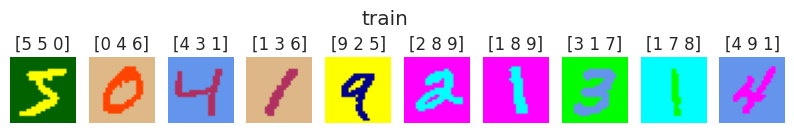

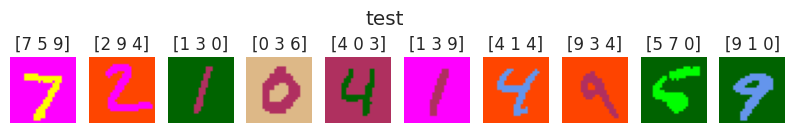

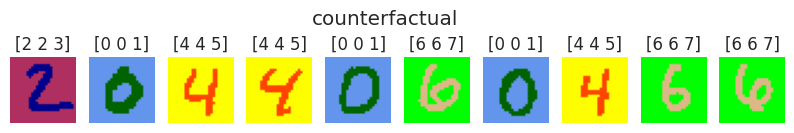

In [ ]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. Build CVAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=2, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3136 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3136 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=2, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=64*7*7)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.first_layer(x).view((-1, 64, 7, 7))
        return self.upsampling_layers(x)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, z_dim=2, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def get_one_hot(self, labels):
        new_ys = []
        for i, label_length in enumerate(LABEL_SIZES):
            new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
            new_ys.append(new_y)
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, self.get_one_hot(labels)], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, self.get_one_hot(labels))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        z_loc, z_scale = self.encoder_(x, y_one_hot)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        loc_img = self.decoder_(torch.cat([z, y_one_hot], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Train CVAE

In [ ]:
def plot_image(x):
    plt.figure(figsize=(3, 3))
    plt.imshow(normalize(x.cpu()))
    plt.axis('off')

def plot_img_on_ax(x, ax):
    ax.imshow(normalize(x.cpu()))
    ax.axis('off')

def show_reconstructions(vae, loader, cols=5, rows=1):
    for k, batch in enumerate(loader):
        if k >= rows:
            return
        x = batch['img']
        l = batch['label']
        plt.figure(figsize=(1.5 * cols, 3))
        for i in range(cols):
            plt.subplot(2, cols, i+1)
            plt.imshow(normalize(x[i].permute(1, 2, 0)))
            plt.axis('off')
            plt.subplot(2, cols, i+cols+1)
            rec_img = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy().transpose((1, 2, 0))
            plt.imshow(normalize(rec_img))
            plt.axis('off')
        plt.tight_layout()

def run_epoch(svi, dataloader, use_cuda=False):
    epoch_loss = 0.
    for batch in dataloader:
        epoch_loss += svi.step(batch['img'], batch['label'])
    return epoch_loss / len(dataloader.dataset)

def callback(train_elbo, test_elbo, test_epoch_num, epoch, vae):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    plt.plot(test_epoch_num, test_elbo, lw=2, color='#FF3300', label='test')
    plt.legend()
    plt.xlabel('epoch')
    plt.title(f'Epoch {epoch}. ELBO {test_elbo[-1]}')
    plt.show()
    vae.train(False);
    show_reconstructions(vae, cf_loader, 2, 1)
    show_reconstructions(vae, test_loader, 2, 1)
    vae.train(True);
    plt.show()


LEARNING_RATE = 5.0e-4
USE_CUDA = torch.cuda.is_available()
pyro.clear_param_store()
adam_args = {"lr": LEARNING_RATE}

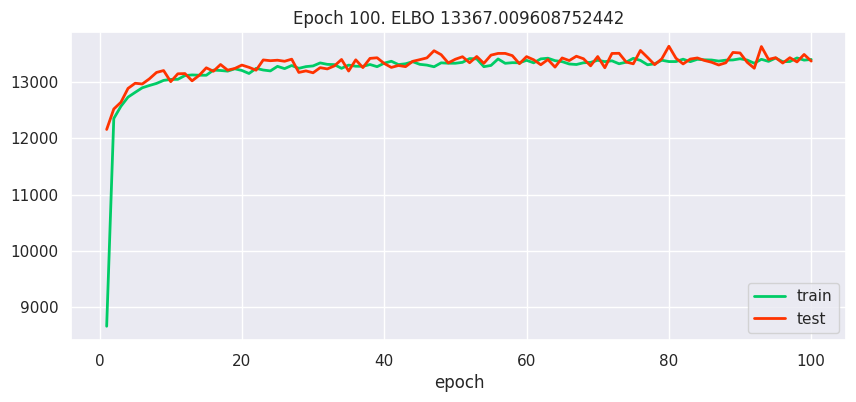

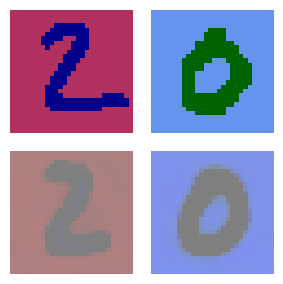

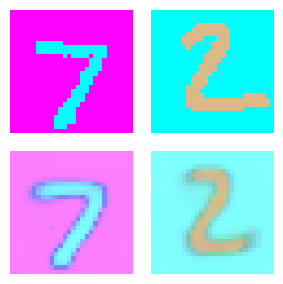

In [ ]:
# 3.4
vae = CVAE(z_dim=3, label_dim=30, p=0.1, use_cuda=USE_CUDA)
optimizer = Adam(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
test_epoch_num = []

for epoch in range(100):
    total_epoch_loss_train = run_epoch(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    total_epoch_loss_test = run_epoch(svi, test_loader, use_cuda=USE_CUDA)
    test_elbo.append(-total_epoch_loss_test)
    test_epoch_num.append(epoch+1)
    if epoch % 2 == 0:
        torch.save(vae.state_dict(), '/content/drive/MyDrive/vae_04_19_exp34.pth')

    callback(train_elbo, test_elbo, test_epoch_num, epoch+1, vae)

In [ ]:
np.save('/content/drive/MyDrive/vae_04_19_exp34_train_elbo.npy', train_elbo)
np.save('/content/drive/MyDrive/vae_04_19_exp34_test_elbo.npy', test_elbo)

### 3.1 CVAE Sanity Checks

In [ ]:
# vae = CVAE(z_dim=2, label_dim=30, p=0.1, use_cuda=USE_CUDA)
# vae.load_state_dict(torch.load('/content/vae_04_18_exp21.pth', map_location='cuda' if USE_CUDA else 'cpu'))
# vae.train(False);

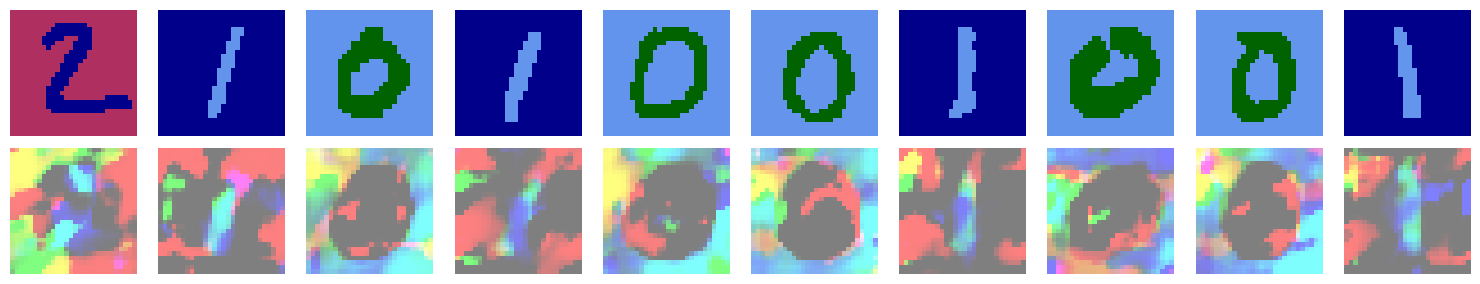

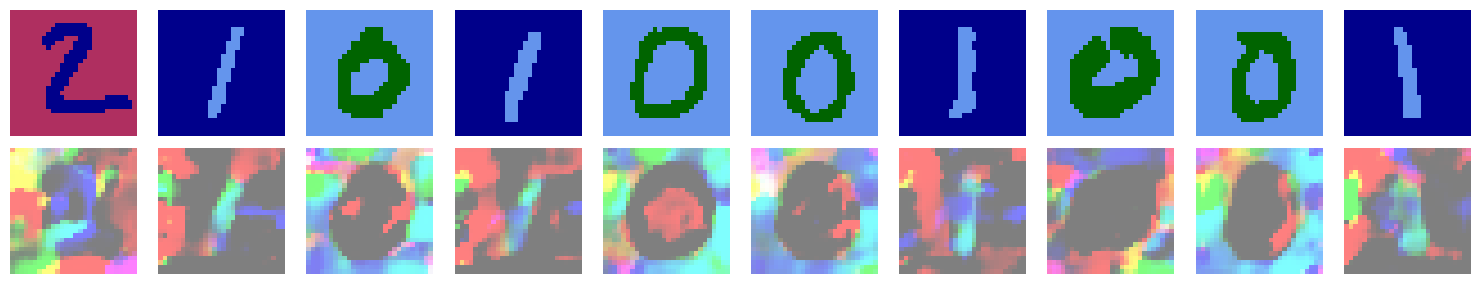

In [ ]:
show_reconstructions(cf_loader, 10, 2);

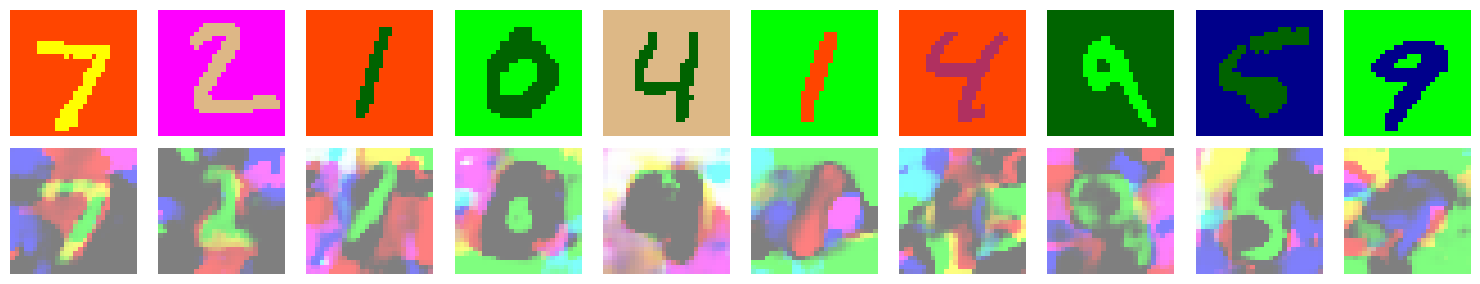

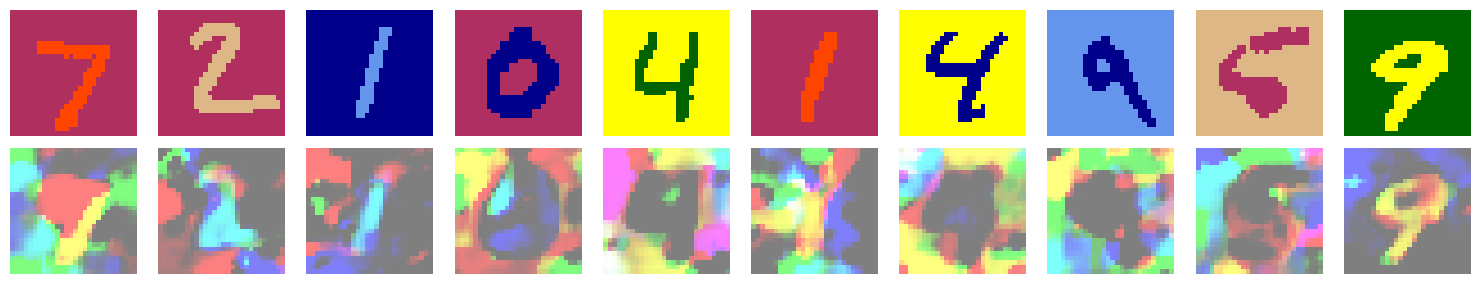

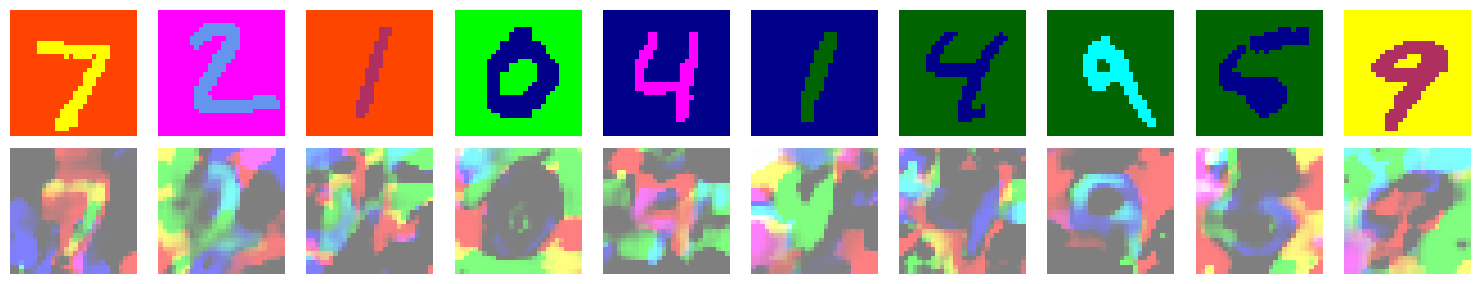

In [ ]:
show_reconstructions(test_loader, 10, 3);

In [ ]:
from scipy.special import expit
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def to_alpha(img):
    h = len(img[0])
    return np.concatenate([img, np.ones((h, h, 1))], axis=-1)

def create_data_image(
    vae,
    data_loader,
    label,
    ymin=-4,
    ymax=4,
    do_expit=False,
    max_pictures=None,
    figsize=(20, 20),
    zoom=0.6,
    fname=None,
    dpi=200,
    axis=False,
    xlabel='',
    ylabel=''
):

    with sns.axes_style('whitegrid' if axis else 'white'):
        fig, ax = plt.subplots(figsize=figsize)
        n_pictures = 0

        for _, (x, l) in enumerate(data_loader):
            x = batch['img']
            l = batch['label']
            if (max_pictures is not None) and (len(x) > max_pictures - n_pictures):
                x = x[:max_pictures - n_pictures]
                l = l[:max_pictures - n_pictures]

            cond = (l[:, 0]==label[0]) & (l[:, 1] == label[1]) & (l[:, 2] == label[2])
            # cond = (l[:, 0]==label)
            x = x[cond]
            l = l[cond]
            if len(x) == 0: continue

            y = vae.encoder(x, l)[0].detach().numpy()
            if do_expit:
                y = expit(y)

            for i in range(len(x)):
                img = normalize(x[i].detach().numpy().transpose(1,2,0))
                img = to_alpha(img)
                imagebox = OffsetImage(img, zoom=zoom)
                ab = AnnotationBbox(imagebox, (y[i, 0], y[i, 1]), frameon=False)
                ax.add_artist(ab)

            n_pictures += len(x)
            if (max_pictures is not None) and (n_pictures >= max_pictures):
                break

        print(n_pictures)
        plt.xlim((ymin, ymax))
        plt.ylim((ymin, ymax))
        if not axis:
            plt.axis('off')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        if fname is not None: plt.savefig(fname, dpi=dpi)

In [ ]:
label = [9, 0, 1]
create_data_image(
    vae, train_loader, label=label, figsize=(30, 30), zoom=1, fname=f'data_{label}.png'
)

In [ ]:
labels = []
y_all = []
i = 0
for batch in train_loader:
    i +=1
    x, l = batch['img'], torch.Tensor(batch['label'])
    labels.append(l.detach().numpy())
    y = vae.encoder(x, l)[0].detach().numpy()
    y_all.append(y)
    if i > 10000:
        break

labels = np.vstack(labels)
y_all = np.vstack(y_all)
colors_ = labels[:,0]*100 + labels[:,1]*10 + labels[:,2]

Text(0, 0.5, 'Значения $Y_2$')

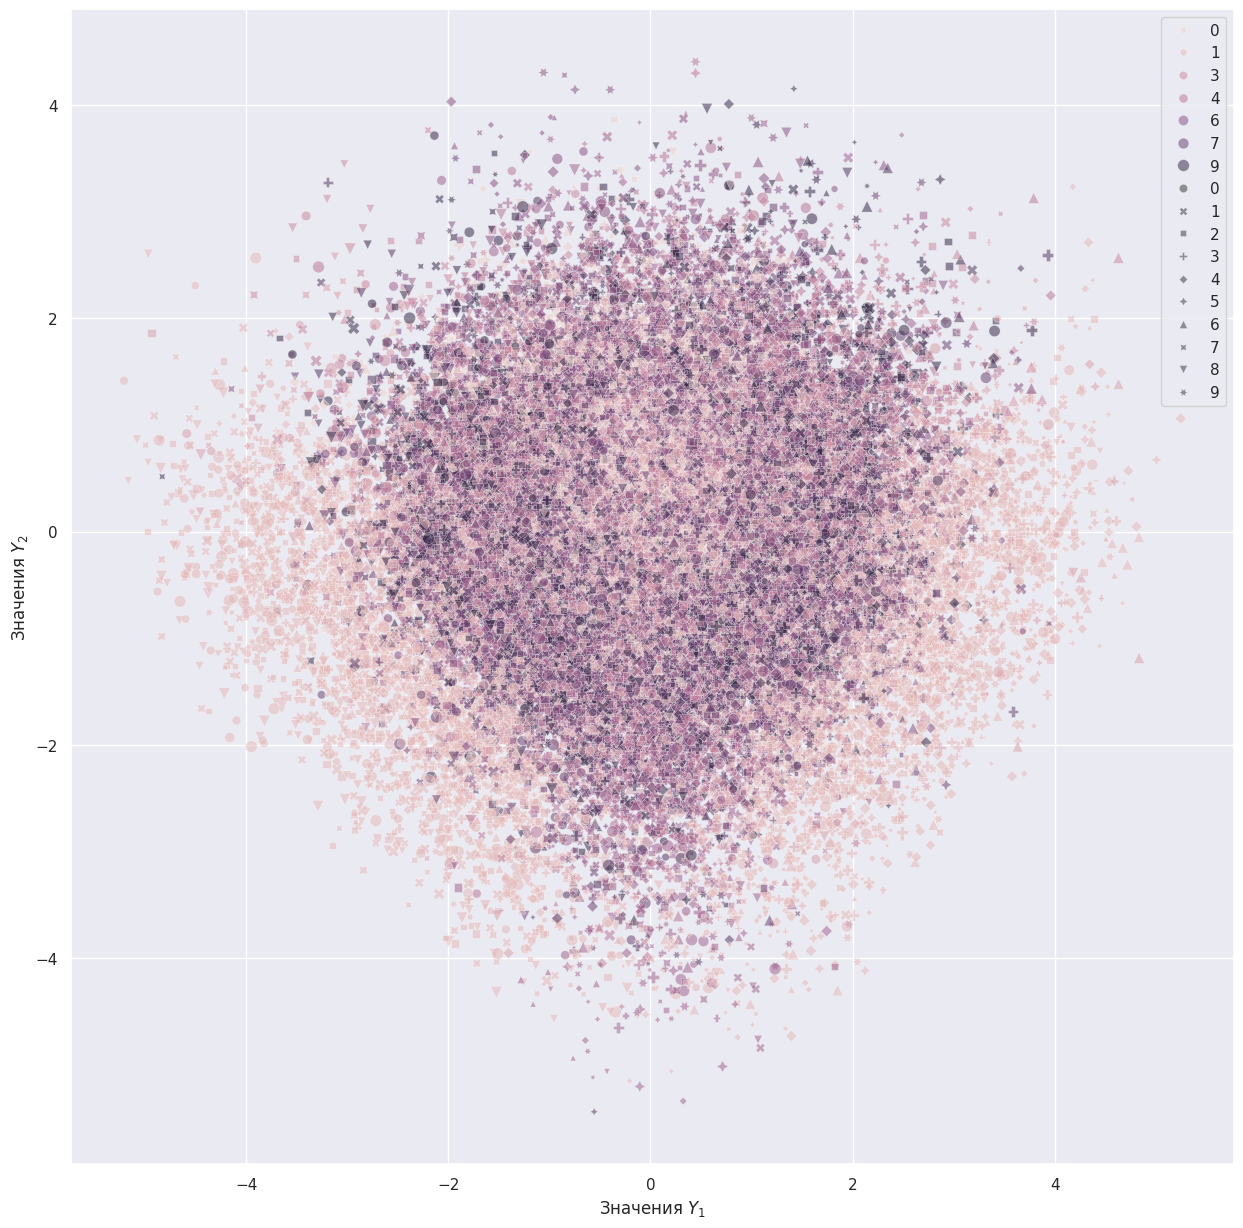

In [ ]:
# plt.figure(figsize=(15, 15))
# sns.scatterplot(x=y_all[:, 0], y=y_all[:, 1], hue=labels[:,0], alpha=0.5, legend='full')
# plt.xlabel('Значения $Y_1$')
# plt.ylabel('Значения $Y_2$');

plt.figure(figsize=(15, 15))
sns.scatterplot(x=y_all[:, 0], y=y_all[:, 1], hue=labels[:,0],
                style=labels[:,1], size=labels[:,2], alpha=0.5)
plt.xlabel('Значения $Y_1$')
plt.ylabel('Значения $Y_2$')

In [ ]:
# original, y_original = get_specific_data(cuda=USE_CUDA)
ox, y = dataset_test[idx]['img'].unsqueeze(0), torch.Tensor(dataset_test[idx]['label']).unsqueeze(0)
print('top original image with no change: ', y_original)
mu, sigma = vae.encoder.forward(original, vae.remap_y(y_original))
B = 100
#Explaination: here zs is being sampled 100 times with new values from distribution
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
#Explaination: here ys is being repeatedly 100 times assigned the same value
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
rs = vae.decoder.forward(zs, ys).detach()
compare_to_density(original, rs)

y_new = torch.tensor(y_original)
y_new[0, 1] = (y_original[0,1] + 1) % 2
print('Middle with change in shape: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
rs = vae.decoder.forward(zs, ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)
y_new[0, 3] = (y_original[0,3] + 1) % 2
print('bottom with change in Orientation: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
rs = vae.decoder.forward(zs, ys).detach()
compare_to_density(original,rs)


### 4. Create dataset for causica with Ys(3) and Zs(2)

In [ ]:
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
causica_train_dataset = pd.DataFrame(columns=LABEL_NAMES+['z'+str(i) for i in range(2)])
for batch in train_loader:
    print(batch['img'], batch['label'])

for i in range(10):
    x, y =  (cuda=USE_CUDA)
    mu, sigma = vae.encoder.forward(x, vae.remap_y(y))
    zs = dist.Normal(mu.cpu(), sigma.cpu()).to_event(1).sample()
    train_dataset.loc[len(train_dataset)] = [y_shape, y_scale, y_orient, y_posx, y_posy] + list(zs.flatten())

### 5. Train causica

In [ ]:
!pip install -q pytorch-lightning

### Required Libraries
We will be importing various libraries and packages to work on with in Causal Variational AutoEncoder Implementation.


In [ ]:
# LOADING NECESSARY LIBRARIES

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
import torch.nn as nn

from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

# Change figure aesthetics

%matplotlib inline
sns.set_context('talk', font_scale=0.8, rc={'lines.linewidth': 1.5})
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets

#to utilize GPU capabilities
# USE_CUDA = True
USE_CUDA = False
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [ ]:
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Visualizing the reconstruction accuracy of VAE

In [ ]:
######LOADING THE SAVED MODEL#############
network_path = "/content/gdrive/MyDrive/thesis/trained_model.save"

vae = CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(network_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Explaination: [1 Cell] Sampled Images of the datset- All possible combination of dsprite images
(Nothing to do with encoder-decoder or CVAE or anything)

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset(shape, scale, orient, posX, posY)>

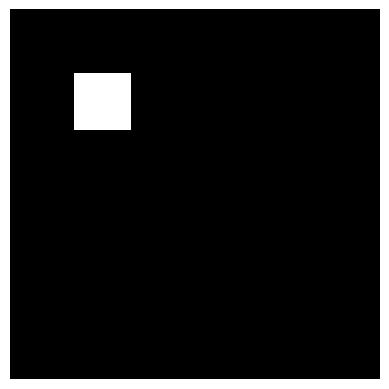

In [ ]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}

for i, img in enumerate(imgs_sampled):
    img_dict[tuple(labels_sampled[i])] = img

# print(img_dict)
def find_in_dataset(shape, scale, orient, posX, posY):
    fig = plt.figure()
    img = img_dict[(0, shape, scale, orient, posX, posY)]
    plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')

interact(find_in_dataset,
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

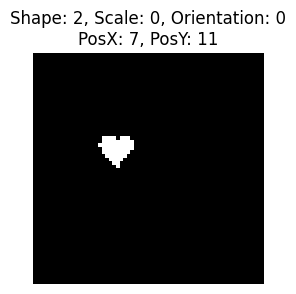

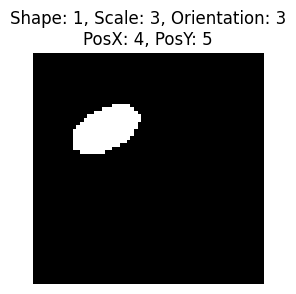

In [ ]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs:
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''

    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    # print(selected_ind)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    # print(ind)
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure(figsize=(3, 3))
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs:
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)


def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

#See random image
see_specific_image()
#See specific image
see_specific_image({'shape': 1, 'scale': 3, 'orientation': 3, 'posX': 4, 'posY': 5})

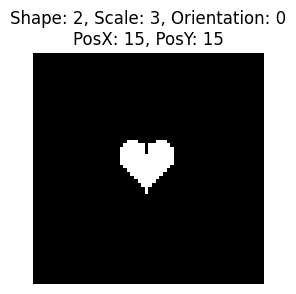

In [ ]:
#See specific image
see_specific_image({'shape': 2, 'scale': 3, 'orientation': 0, 'posX': 15, 'posY': 15})

### Sanity Check on Working of CVAE

##Sanity Check [1]

Description - Make sure that the VAE is working properly. We will do this by generating a single image from the dataset and reconstructing it using sampling from VAE.

From the results in  the figure attached, we can observe that the Sanity Check [1] passed as we were able to generate the exact same image using the CVAE.

In [ ]:
USE_CUDA = False

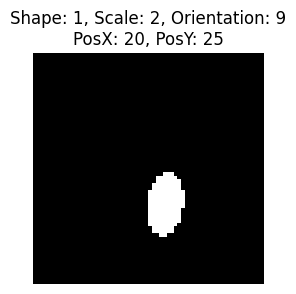

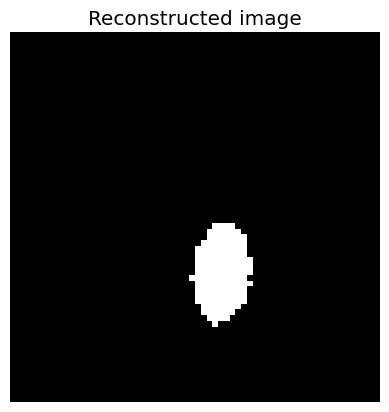

In [ ]:
# Generate an instance of dSprites image
ox, y = get_specific_data(cuda=USE_CUDA)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(ox, vae.remap_y(y))
string = ''
for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
    string += '%s: %d, ' % (s, int(y[0][i+1]))
    if i == 2:
        string = string[:-2] + '\n'
plot_image(ox)
plt.title(string[:-2], fontsize=12)
plt.show()
# Check for reconstruction
zs = dist.Normal(mu.cpu(), sigma.cpu()).to_event(1).sample()
# loc = vae.decoder.forward(zs.cuda(), vae.remap_y(y))
loc = vae.decoder.forward(zs, vae.remap_y(y))
recon = dist.Bernoulli(loc).to_event(1).sample()
recon = recon.reshape(64,64)
plt.imshow(recon.cpu(), cmap='Greys_r', interpolation='nearest')
plt.axis('off')
plt.title('Reconstructed image')
plt.show()

Dataset:

In [ ]:
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dataset = pd.DataFrame(columns=['y'+str(i) for i in range(5)]+['z'+str(i) for i in range(50)])
for y_shape in tqdm(range(3)):
    for y_scale in range(6):
        for y_orient in range(40):
            for y_posx in range(32):
                for y_posy in range(32):
                    if y_shape == 0 and y_orient != 0:
                        continue
                    if y_shape == 1 and y_scale != 3:
                        continue
                    if y_shape == 2 and (y_posx != 15 or y_posy != 15):
                        continue
                    x, y = get_specific_data(cuda=USE_CUDA)
                    mu, sigma = vae.encoder.forward(x, vae.remap_y(y))
                    zs = dist.Normal(mu.cpu(), sigma.cpu()).to_event(1).sample()
                    train_dataset.loc[len(train_dataset)] = [y_shape, y_scale, y_orient, y_posx, y_posy] + list(zs.flatten())

Continue:

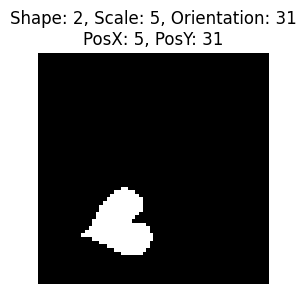

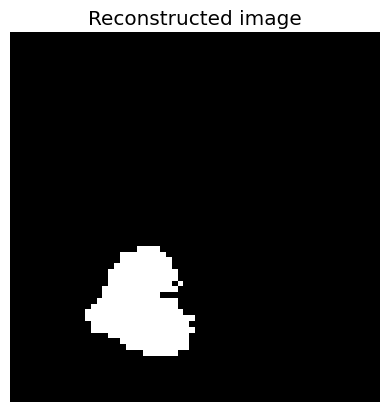

In [ ]:
# Generate an instance of dSprites image
ox, y = get_specific_data(cuda=USE_CUDA)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(ox,vae.remap_y(y))
string = ''
for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
    string += '%s: %d, ' % (s, int(y[0][i+1]))
    if i == 2:
        string = string[:-2] + '\n'
plot_image(ox)
plt.title(string[:-2], fontsize=12)
plt.show()
# Check for reconstruction
zs = dist.Normal(mu.cpu(), sigma.cpu()).to_event(1).sample()
# loc = vae.decoder.forward(zs.cuda(), vae.remap_y(y))
loc = vae.decoder.forward(zs, vae.remap_y(y))
recon = dist.Bernoulli(loc).to_event(1).sample()
recon = recon.reshape(64,64)
plt.imshow(recon.cpu(), cmap='Greys_r',  interpolation='nearest')
plt.axis('off')
plt.title('Reconstructed image')
plt.show()

### Sanity Check [2]
Description - To ensure proper functioning of the decoder, by checking the decoder is able to generate the images if the latents are changed manually. We will implement this by manually changing the latents in the code and run it through the decoder and check for the reconstruction.

 From the results attached in the figure, we can observe that we manually changed the shape of the original image from square to an oval, the decoder worked well and generated an oval without changing any other latent variable for the original image.



In [ ]:
rs.shape

torch.Size([100, 4096])

top original image with no change:  tensor([[ 0.,  2.,  4., 30.,  8., 24.]])
Middle with change in shape:  tensor([[ 0.,  1.,  4., 30.,  8., 24.]])
bottom with change in Orientation:  tensor([[ 0.,  2.,  4.,  1.,  8., 24.]])


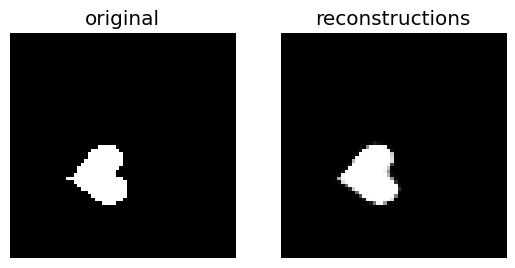

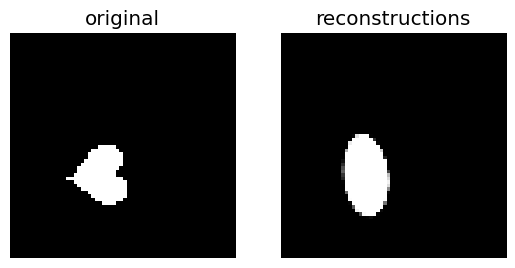

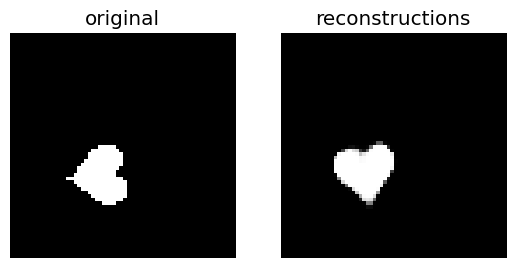

In [ ]:
original, y_original = get_specific_data(cuda=USE_CUDA)
print('top original image with no change: ', y_original)
mu, sigma = vae.encoder.forward(original, vae.remap_y(y_original))
B = 100
#Explaination: here zs is being sampled 100 times with new values from distribution
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
#Explaination: here ys is being repeatedly 100 times assigned the same value
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
rs = vae.decoder.forward(zs, ys).detach()
compare_to_density(original, rs)

y_new = torch.tensor(y_original)
y_new[0, 1] = (y_original[0,1] + 1) % 2
print('Middle with change in shape: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
rs = vae.decoder.forward(zs, ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)
y_new[0, 3] = (y_original[0,3] + 1) % 2
print('bottom with change in Orientation: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
rs = vae.decoder.forward(zs, ys).detach()
compare_to_density(original,rs)


### Using Zs in CAUSICA

In [ ]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 34.0 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
seed = 1
pl.seed_everything(seed)  # set the random seed

INFO:lightning_fabric.utilities.seed:Seed set to 1


1

In [ ]:
!pip install -q causica tensordict

In [ ]:
!pip install -q tensordict

In [ ]:
import os
from dataclasses import dataclass

import networkx as nx
import torch
from tensordict import TensorDict
from torch.utils.data import DataLoader

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, DataEnum, load_data, VariablesMetadata
from causica.datasets.tensordict_utils import tensordict_shapes
from causica.distributions import (
    AdjacencyDistribution,
    ContinuousNoiseDist,
    DistributionModule,
    ENCOAdjacencyDistributionModule,
    GibbsDAGPrior,
    JointNoiseModule,
    create_noise_modules,
)
from causica.functional_relationships import DECIEmbedFunctionalRelationships
from causica.graph.dag_constraint import calculate_dagness
from causica.sem.sem_distribution import SEMDistributionModule
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig

Define various parameters of the training process.

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist: ContinuousNoiseDist = ContinuousNoiseDist.SPLINE
    batch_size: int = 128
    max_epoch: int = int(os.environ.get("TEST_RUN", 2000))  # used by testing to run the notebook as a script
    gumbel_temp: float = 0.25
    averaging_period: int = 10
    prior_sparsity_lambda: float = 5.0
    init_rho: float = 1.0
    init_alpha: float = 0.0


training_config = TrainingConfig()
auglag_config = AugLagLRConfig()
device = "cuda" if torch.cuda.is_available() else "cpu"

We now download the dataset from Azure Blob storage.

The Causica repo makes heavy use of [TensorDict](https://pytorch.org/rl/tensordict/reference/generated/tensordict.TensorDict.html). A dataset is assumed to be a TensorDict, with each key containing the data associated with a given node.

The `variables_metadata` object stored with the CSuite data also describes the type of each node, which we will need when we create the Noise Distributions for each node.

In [ ]:
root_path = '.'
variables_metadata = load_data(root_path, DataEnum.VARIABLES_JSON)

In [ ]:
pd.read_csv('train.csv', index_col=0).to_csv('train.csv', index=False)

In [ ]:
dataset_train: TensorDict = load_data(root_path, DataEnum.TRAIN, variables_metadata)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
)

Create a prior distribution over DAGs.

In [ ]:
num_nodes = len(dataset_train.keys())

prior = GibbsDAGPrior(num_nodes=num_nodes, sparsity_lambda=training_config.prior_sparsity_lambda)
num_nodes

55

In [ ]:
print(prior.batch_shape, prior.event_shape)
prior._num_nodes, prior._expert_graph_container, prior._sparsity_lambda

torch.Size([]) torch.Size([55, 55])


(55, None, 5.0)

Create the Variational Posterior Distribution over Adjacency Matrices, which we will optimize.

In [ ]:
adjacency_dist: DistributionModule[AdjacencyDistribution] = ENCOAdjacencyDistributionModule(num_nodes)

In [ ]:
adjacency_dist.logits_exist, adjacency_dist.logits_orient

(Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True))

In [ ]:
logits = adjacency_dist()._get_independent_bernoulli_logits()
logits

tensor([[-1.0986, -1.0986, -1.0986,  ..., -1.0986, -1.0986, -1.0986],
        [-1.0986, -1.0986, -1.0986,  ..., -1.0986, -1.0986, -1.0986],
        [-1.0986, -1.0986, -1.0986,  ..., -1.0986, -1.0986, -1.0986],
        ...,
        [-1.0986, -1.0986, -1.0986,  ..., -1.0986, -1.0986, -1.0986],
        [-1.0986, -1.0986, -1.0986,  ..., -1.0986, -1.0986, -1.0986],
        [-1.0986, -1.0986, -1.0986,  ..., -1.0986, -1.0986, -1.0986]],
       grad_fn=<NegBackward0>)

In [ ]:
adjacency_dist().base_dist(logits)

Independent(Bernoulli(logits: torch.Size([55, 55])), 2)

In [ ]:
adjacency_dist().relaxed_sample(torch.Size([2]))

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<MulBackward0>)

In [ ]:
adjacency_dist().entropy()

tensor(1670.1349, grad_fn=<SubBackward0>)

In [ ]:
adjacency_dist().mean

tensor([[0.0000, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        [0.2500, 0.0000, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000,  ..., 0.2500, 0.2500, 0.2500],
        ...,
        [0.2500, 0.2500, 0.2500,  ..., 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.0000, 0.2500],
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.0000]],
       grad_fn=<MulBackward0>)

In [ ]:
adjacency_dist().mode

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
adjacency_dist().log_prob(torch.eye(55).unsqueeze(0).unsqueeze(0))

tensor([[-854.4155]], grad_fn=<SubBackward0>)

Create the Graph Neural network that will estimate the functional relationships. More info can be found [here](https://openreview.net/forum?id=S2pNPZM-w-f).

In [ ]:
functional_relationships = DECIEmbedFunctionalRelationships(
    shapes=tensordict_shapes(dataset_train),
    embedding_size=32,
    out_dim_g=32,
    num_layers_g=2,
    num_layers_zeta=2,
)

In [ ]:
tensordict_shapes(dataset_train)

{'y0': torch.Size([3]),
 'y1': torch.Size([6]),
 'y2': torch.Size([40]),
 'y3': torch.Size([32]),
 'y4': torch.Size([32]),
 'z0': torch.Size([1]),
 'z1': torch.Size([1]),
 'z2': torch.Size([1]),
 'z3': torch.Size([1]),
 'z4': torch.Size([1]),
 'z5': torch.Size([1]),
 'z6': torch.Size([1]),
 'z7': torch.Size([1]),
 'z8': torch.Size([1]),
 'z9': torch.Size([1]),
 'z10': torch.Size([1]),
 'z11': torch.Size([1]),
 'z12': torch.Size([1]),
 'z13': torch.Size([1]),
 'z14': torch.Size([1]),
 'z15': torch.Size([1]),
 'z16': torch.Size([1]),
 'z17': torch.Size([1]),
 'z18': torch.Size([1]),
 'z19': torch.Size([1]),
 'z20': torch.Size([1]),
 'z21': torch.Size([1]),
 'z22': torch.Size([1]),
 'z23': torch.Size([1]),
 'z24': torch.Size([1]),
 'z25': torch.Size([1]),
 'z26': torch.Size([1]),
 'z27': torch.Size([1]),
 'z28': torch.Size([1]),
 'z29': torch.Size([1]),
 'z30': torch.Size([1]),
 'z31': torch.Size([1]),
 'z32': torch.Size([1]),
 'z33': torch.Size([1]),
 'z34': torch.Size([1]),
 'z35': torc

In [ ]:
functional_relationships.nn.group_mask

Parameter containing:
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
num_nodes, concatenated_shape = functional_relationships.nn.group_mask.shape
num_nodes, concatenated_shape

(55, 163)

In [ ]:
functional_relationships

DECIEmbedFunctionalRelationships(
  (nn): DECIEmbedNN(
    (l): Sequential(
      (0): Sequential(
        (0): Linear(in_features=195, out_features=652, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): _ResBlock(
        (block): Sequential(
          (0): LayerNorm((652,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=652, out_features=652, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): LayerNorm((652,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=652, out_features=32, bias=True)
    )
    (zeta): Sequential(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=652, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): _ResBlock(
        (block): Sequential(
          (0): LayerNorm((652,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=652, out_features=652, bias=True)
          (2): LeakyReLU(negative_slope=0.01)

In [ ]:
from torchsummary import summary
batch_shape_x = 1
batch_shape_f = 2
batch_shape_g = 3
n_cols = 163
n_nodes = 55

In [ ]:
samples = torch.rand([batch_shape_x, batch_shape_f, batch_shape_g, n_cols])
graphs = torch.rand([batch_shape_g, n_nodes, n_nodes])

In [ ]:
# forward ouput shape
functional_relationships.nn(samples, graphs).shape

torch.Size([1, 2, 3, 163])

In [ ]:
functional_relationships.nn(samples, graphs)

tensor([[[[-0.0958, -0.6084, -0.7982, -0.3018, -0.3419, -0.7305,  0.7687,
           -0.0388, -0.2242, -1.2460,  0.2120,  0.0994, -0.0474, -0.1669,
            0.3046, -0.0526, -0.8611, -0.1922,  0.7556, -0.2254,  0.0705,
            0.4672,  0.1024,  0.0488,  0.6220,  0.7861,  0.5371, -0.3934,
            0.4676, -0.6300,  0.2741, -0.0213, -0.0961,  0.4406, -0.2715,
           -0.6947,  0.3553, -0.2653, -1.0590, -0.4180, -0.4088,  0.0026,
            0.1237, -0.1570,  0.2141,  0.4724, -0.2711, -1.6505, -0.1856,
           -0.4425, -1.4108,  0.2264,  0.4615,  0.2704,  0.9823, -0.0094,
            0.2095, -0.2431, -0.6928,  0.6412,  0.7826,  0.6391,  0.1648,
           -0.3863,  0.1225,  1.0045, -0.1083,  0.2268, -1.0434,  0.1663,
           -0.3037, -0.6069, -0.4776,  0.0864,  0.8289,  0.1621, -0.2208,
            1.1127,  0.5430, -0.6578, -0.1337,  0.0372, -0.9703,  0.6485,
           -0.0717, -1.0061, -1.0625, -0.3530, -0.1828, -0.4565,  0.4470,
           -0.4717,  0.2908, -0.0950, 

Create the Noise Distributions for each node using the definitions in `variables_metadata`.

In [ ]:
variable_shapes = tensordict_shapes(dataset_train)

types_dict = {var.group_name: var.type for var in variables_metadata.variables}

noise_submodules = create_noise_modules(variable_shapes, types_dict, training_config.noise_dist)
noise_module = JointNoiseModule(noise_submodules)

In [ ]:
noise_submodules['z0']().base_dist

SplineNoise()

In [ ]:
noise_submodules['y0']()

CategoricalNoise()

Create the SEM Module which combines the variational adjacency distribution, the functional relationships and the noise distributions for each node.

In [ ]:
sem_module: SEMDistributionModule = SEMDistributionModule(adjacency_dist, functional_relationships, noise_module)

sem_module.to(device);

In [ ]:
sem_module()

SEMDistribution()

In [ ]:
sem_module

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): DECIEmbedFunctionalRelationships(
    (nn): DECIEmbedNN(
      (l): Sequential(
        (0): Sequential(
          (0): Linear(in_features=195, out_features=652, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((652,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=652, out_features=652, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((652,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=652, out_features=32, bias=True)
      )
      (zeta): Sequential(
        (0): Sequential(
          (0): Linear(in_features=64, out_features=652, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm(

Create the optimizer, with separate learning rates for each module.

In [ ]:
modules = {
    "functional_relationships": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

optimizer = torch.optim.Adam(parameter_list)

Define the [Augmented Lagrangian Scheduler](https://en.wikipedia.org/wiki/Augmented_Lagrangian_method).

This allows DECI to optimize towards a DAG, by slowly increasing the alpha and rho parameters as the optimization takes place

In [ ]:
scheduler = AugLagLR(config=auglag_config)
auglag_loss = AugLagLossCalculator(init_alpha=training_config.init_alpha, init_rho=training_config.init_rho)

The main training loop.

For each batch, we:
* Sample a graph from the SEM.
* Calculate the log probability of that batch, given the graph.
* Create the ELBO to be optimized.
* Calculate the DAG constraint
* Combine the DAG constraint with the ELBO to get the loss.

In [ ]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"
num_samples = len(dataset_train)
for epoch in range(training_config.max_epoch):
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), temperature=training_config.gumbel_temp
        )  # soft sample

        batch_log_prob = sem.log_prob(batch).mean()
        sem_distribution_entropy = sem_distribution.entropy()
        prior_term = prior.log_prob(sem.graph)
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        constraint = calculate_dagness(sem.graph)

        loss = auglag_loss(objective, constraint / num_samples)

        loss.backward()
        optimizer.step()
        # update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss,
            lagrangian_penalty=constraint,
        )
        # log metrics
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )

epoch:0 loss:7.0641 nll:7.0575 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:10 loss:1.8038 nll:1.79 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|161 num_lr_updates:0
epoch:20 loss:1.2414 nll:1.2272 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|321 num_lr_updates:0
epoch:30 loss:1.1883 nll:1.1763 dagness:1.01673 num_edges:5 alpha:0 rho:1 step:0|481 num_lr_updates:0
epoch:40 loss:0.94057 nll:0.92857 dagness:1.01673 num_edges:5 alpha:0 rho:1 step:0|641 num_lr_updates:0
epoch:50 loss:0.96788 nll:0.95574 dagness:1.01673 num_edges:5 alpha:0 rho:1 step:0|801 num_lr_updates:0
epoch:60 loss:1.1962 nll:1.184 dagness:1.01673 num_edges:5 alpha:0 rho:1 step:0|961 num_lr_updates:0
epoch:70 loss:0.97807 nll:0.96576 dagness:1.01673 num_edges:5 alpha:0 rho:1 step:0|1121 num_lr_updates:0
epoch:80 loss:0.85117 nll:0.8389 dagness:1.01673 num_edges:5 alpha:0 rho:1 step:0|1281 num_lr_updates:0
epoch:90 loss:0.97985 nll:0.96759 dagness:1.01673 num_edges:5 alpha:0 rho:1 ste